In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

import torch
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch import Trainer

from ray.train.lightning import (
    RayDDPStrategy,
    RayLightningEnvironment,
    RayTrainReportCallback,
    prepare_trainer,
)

from shared_decoding.utils.ibl_data_utils import seed_everything
from shared_decoding.utils.ibl_data_loaders import SingleSessionDataModule
from shared_decoding.models.neural_models import ReducedRankDecoder, MLPDecoder, LSTMDecoder, eval_model
from shared_decoding.utils.hyperparam_tuning import tune_decoder

from ray import tune

seed_everything(0)

/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/neurodsp/__init__.py:5: FutureWarning: neurodsp has been renamed to ibldsp and the old name will be deprecated on 01-Sep-2024.
  warn(


In [2]:
base_dir = Path('/mnt/3TB/yizi/shared_decoding')
data_dir = base_dir/'data'

eids = [fname.split('.')[0] for fname in os.listdir(data_dir) if fname.endswith('npz')]
print(eids)

['d32876dd-8303-4720-8e7e-20678dc2fd71', '03d9a098-07bf-4765-88b7-85f8d8f620cc', '3f859b5c-e73a-4044-b49e-34bb81e96715', '8c33abef-3d3e-4d42-9f27-445e9def08f9', '12dc8b34-b18e-4cdd-90a9-da134a9be79c', 'cc45c568-c3b9-4f74-836e-c87762e898c8']


In [3]:
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

config = {
    'data_dir': data_dir,
    'temporal_rank': tune.grid_search([5, 2]),
    'weight_decay': 1e-1,
    'learning_rate': 1e-2,
    'batch_size': 8,
    'eid': eids[3],
    'imposter_id': None,
    'target': 'wheel_speed',
    'lstm_hidden_size': 32,
    'lstm_n_layers': 3,
    'mlp_hidden_size': (256, 128, 64),
    'drop_out': 0.,
    'lr_factor': 0.1,
    'lr_patience': 5,
    'device': DEVICE,
    'n_workers': os.cpu_count()
}

#### Train Reduced Rank Decoder

In [4]:
def train_func(config):
    dm = SingleSessionDataModule(config)
    dm.setup()
    model = ReducedRankDecoder(dm.config)

    trainer = Trainer(
        max_epochs=500,
        devices="auto",
        accelerator="auto",
        strategy=RayDDPStrategy(),
        callbacks=[RayTrainReportCallback()],
        plugins=[RayLightningEnvironment()],
        enable_progress_bar=False,
    )
    trainer = prepare_trainer(trainer)
    trainer.fit(model, datamodule=dm)

In [ ]:
results = tune_decoder(train_func, config, use_gpu=False, max_epochs=100, num_samples=1, num_workers=2)

(TrainTrainable pid=61833) /home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/neurodsp/__init__.py:5: FutureWarning: neurodsp has been renamed to ibldsp and the old name will be deprecated on 01-Sep-2024.
(TrainTrainable pid=61833)   warn(
(TrainTrainable pid=61833) GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
(TorchTrainer pid=61833) GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
(TorchTrainer pid=61832) Started distributed worker processes: 
(TorchTrainer pid=61832) - (ip=129.236.160.107, pid=62027) world_rank=0, local_rank=0, node_rank=0
(TorchTrainer pid=61832) - (ip=129.236.160.107, pid=62029) world_rank=1, local_rank=1, node_rank=0
(RayTrainWorker pid=62027) Setting up process group for: env:// [rank=0, worl

(RayTrainWorker pid=62027) spike data shape: (714, 50, 1255)
(RayTrainWorker pid=62027) behavior data shape: (714, 50)


(TrainTrainable pid=62697) /home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/neurodsp/__init__.py:5: FutureWarning: neurodsp has been renamed to ibldsp and the old name will be deprecated on 01-Sep-2024.
(TrainTrainable pid=62697)   warn(
(TrainTrainable pid=62698) GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
(RayTrainWorker pid=62894) Setting up process group for: env:// [rank=0, world_size=2]
(TorchTrainer pid=62697) Started distributed worker processes: 
(TorchTrainer pid=62697) - (ip=129.236.160.107, pid=62894) world_rank=0, local_rank=0, node_rank=0
(TorchTrainer pid=62697) - (ip=129.236.160.107, pid=62895) world_rank=1, local_rank=1, node_rank=0
(RayTrainWorker pid=62904) /home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/neurodsp/__init__.py:5: FutureWarning: neurodsp has been renamed to ibldsp and the o

(RayTrainWorker pid=62895) spike data shape: (714, 50, 1255)
(RayTrainWorker pid=62895) behavior data shape: (714, 50)


(TorchTrainer pid=62699) GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config. [repeated 7x across cluster]
(RayTrainWorker pid=62895) Missing logger folder: /home/yizi/ray_results/TorchTrainer_2024-02-29_15-36-44/TorchTrainer_404ad_00000_0_mlp_hidden_size=128_64_32,weight_decay=0.0010_2024-02-29_15-36-44/lightning_logs
(RayTrainWorker pid=62894) GPU available: False, used: False
(RayTrainWorker pid=62894) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=62894) IPU available: False, using: 0 IPUs
(RayTrainWorker pid=62894) HPU available: False, using: 0 HPUs
(RayTrainWorker pid=62914) Setting up process group for: env:// [rank=0, world_size=2] [repeated 3x across cluster]
(TorchTrainer pid=62700) Started distributed worker processes:  [repeated 3x across cluster]
(TorchTrainer pid=62700) - (ip=129.236.160.107, pid=62915) world_rank=1, local_rank=1, node_rank

In [6]:
best_result = results.get_best_result(metric="val_loss", mode="min")
best_config = best_result.config['train_loop_config']
best_config

{'data_dir': PosixPath('/mnt/3TB/yizi/shared_decoding/data'),
 'temporal_rank': 2,
 'weight_decay': 0.1,
 'learning_rate': 0.01,
 'batch_size': 8,
 'eid': '8c33abef-3d3e-4d42-9f27-445e9def08f9',
 'imposter_id': None,
 'target': 'wheel_speed',
 'lstm_hidden_size': 32,
 'lstm_n_layers': 3,
 'mlp_hidden_size': (256, 128, 64),
 'drop_out': 0.0,
 'lr_factor': 0.1,
 'lr_patience': 5,
 'device': device(type='cpu'),
 'n_workers': 16}

In [ ]:
model_path = base_dir / 'models'
os.makedirs(model_path, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss', mode='min', dirpath=model_path
)

trainer = Trainer(max_epochs=500, callbacks=[checkpoint_callback], enable_progress_bar=False)
dm = SingleSessionDataModule(best_config)
dm.setup()
model = ReducedRankDecoder(best_config)

trainer.fit(model, datamodule=dm)
trainer.test(datamodule=dm, ckpt_path='best')

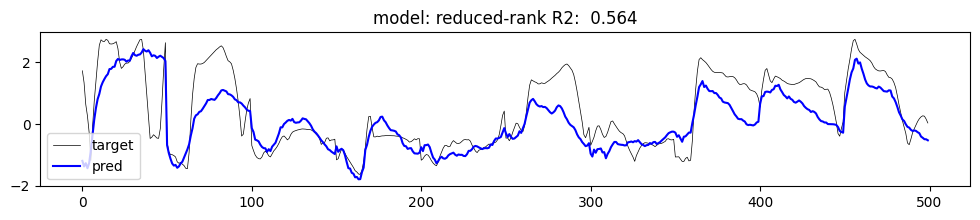

In [8]:
r2, test_pred, test_y = eval_model(dm.train, dm.test, model, model_type="reduced-rank", plot=True)

#### Train Linear Decoder

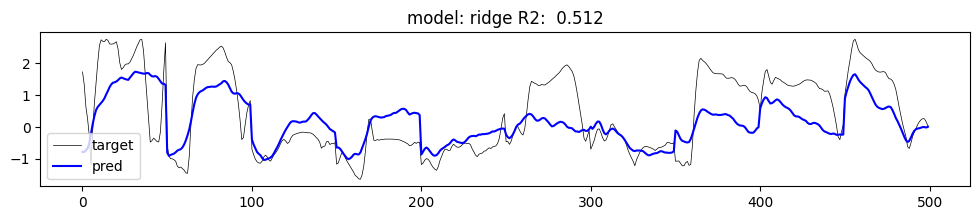

In [18]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
model = GridSearchCV(Ridge(), {"alpha": alphas})
r2, test_pred, test_y = eval_model(dm.train, dm.test, model, model_type="ridge", plot=True)

#### Train LSTM Decoder

In [19]:
config = {
    'data_dir': data_dir,
    'temporal_rank': 5,
    'weight_decay': 1e-3,
    'learning_rate': 1e-3,
    'batch_size': 8,
    'eid': eids[3],
    'imposter_id': None,
    'target': 'wheel_speed',
    'lstm_hidden_size': 32,
    'lstm_n_layers': 5,
    'mlp_hidden_size': (32,),
    'drop_out': 0.1,
    'lr_factor': 0.,
    'lr_patience': 5,
    'device': DEVICE,
    'n_workers': os.cpu_count()
}

In [14]:
def train_func(config):
    dm = SingleSessionDataModule(config)
    dm.setup()
    model = LSTMDecoder(dm.config)

    trainer = Trainer(
        max_epochs=500,
        devices="auto",
        accelerator="auto",
        strategy=RayDDPStrategy(),
        callbacks=[RayTrainReportCallback()],
        plugins=[RayLightningEnvironment()],
        enable_progress_bar=False,
    )
    trainer = prepare_trainer(trainer)
    trainer.fit(model, datamodule=dm)

In [15]:
results = tune_decoder(train_func, config, use_gpu=False, max_epochs=100, num_samples=1, num_workers=2)

2024-03-02 14:47:20,948	INFO data_parallel_trainer.py:344 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
2024-03-02 14:51:05,657	INFO tune.py:1042 -- Total run time: 224.72 seconds (224.71 seconds for the tuning loop).


In [16]:
best_result = results.get_best_result(metric="val_loss", mode="min")
best_config = best_result.config['train_loop_config']
best_config

{'data_dir': PosixPath('/mnt/3TB/yizi/shared_decoding/data'),
 'temporal_rank': 5,
 'weight_decay': 0.001,
 'learning_rate': 0.001,
 'batch_size': 8,
 'eid': '8c33abef-3d3e-4d42-9f27-445e9def08f9',
 'imposter_id': None,
 'target': 'wheel_speed',
 'lstm_hidden_size': 16,
 'lstm_n_layers': 5,
 'mlp_hidden_size': (16,),
 'drop_out': 0.0,
 'lr_factor': 0.0,
 'lr_patience': 5,
 'device': device(type='cpu'),
 'n_workers': 16}

In [35]:
best_config['learning_rate'] = 1e-3
best_config['weight_decay'] = 1e-3
best_config['lstm_hidden_size'] = 64
best_config['mlp_hidden_size'] = (32,)
best_config['drop_out'] = 0.1

In [36]:
model_path = base_dir / 'models'
os.makedirs(model_path, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss', mode='min', dirpath=model_path
)

trainer = Trainer(max_epochs=100, callbacks=[checkpoint_callback], enable_progress_bar=True)
dm = SingleSessionDataModule(best_config)
dm.setup()
model = LSTMDecoder(best_config)

trainer.fit(model, datamodule=dm)
trainer.test(datamodule=dm, ckpt_path='best')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


spike data shape: (714, 50, 1255)
behavior data shape: (714, 50)
spike data shape: (714, 50, 1255)
behavior data shape: (714, 50)


/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /mnt/3TB/yizi/shared_decoding/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params
--------------------------------------------
0 | r2_score     | R2Score    | 0     
1 | lstm         | LSTM       | 1.2 M 
2 | input_layer  | Linear     | 8.3 K 
3 | hidden       | ModuleList | 0     
4 | output_layer | Linear     | 3.2 K 
--------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.996     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


spike data shape: (714, 50, 1255)
behavior data shape: (714, 50)


Restoring states from the checkpoint path at /mnt/3TB/yizi/shared_decoding/models/epoch=55-step=4032.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/3TB/yizi/shared_decoding/models/epoch=55-step=4032.ckpt
/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6048494614585017
         test_r2            0.43995916843414307
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6048494614585017, 'test_r2': 0.43995916843414307}]

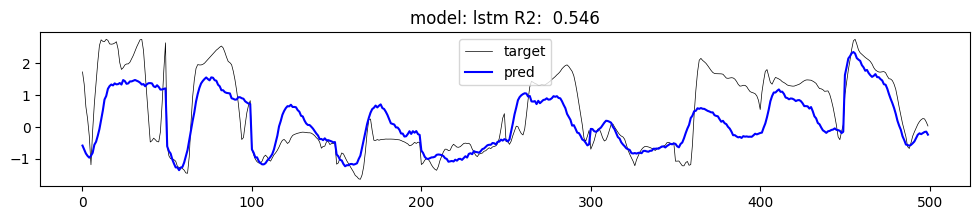

In [34]:
r2, test_pred, test_y = eval_model(dm.train, dm.test, model, model_type="lstm", plot=True)

#### Train MLP Decoder

In [17]:
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

config = {
    'data_dir': data_dir,
    'temporal_rank': 5,
    'weight_decay': tune.grid_search([1e-3, 1e-1]),
    'learning_rate': 1e-3,
    'batch_size': 8,
    'eid': eids[3],
    'imposter_id': None,
    'target': 'wheel_speed',
    'lstm_hidden_size': 32,
    'lstm_n_layers': 3,
    'mlp_hidden_size': tune.grid_search([(256, 128, 64)]),
    'drop_out': 0.,
    'lr_factor': 0.1,
    'lr_patience': 5,
    'device': DEVICE,
    'n_workers': os.cpu_count()
}

In [18]:
def train_func(config):
    dm = SingleSessionDataModule(config)
    dm.setup()
    model = MLPDecoder(dm.config)

    trainer = Trainer(
        max_epochs=500,
        devices="auto",
        accelerator="auto",
        strategy=RayDDPStrategy(),
        callbacks=[RayTrainReportCallback()],
        plugins=[RayLightningEnvironment()],
        enable_progress_bar=False,
    )
    trainer = prepare_trainer(trainer)
    trainer.fit(model, datamodule=dm)

In [19]:
results = tune_decoder(train_func, config, use_gpu=False, max_epochs=100, num_samples=1, num_workers=2)

2024-03-02 12:43:33,675	INFO data_parallel_trainer.py:344 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
2024-03-02 12:43:33,678	INFO data_parallel_trainer.py:344 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
2024-03-02 12:45:09,576	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'train_loop_config/mlp_hidden_size': (256, 128, 64)}
2024-03-02 12:47:32,762	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'train_loop_config/mlp_hidden_size': (256, 128, 64)}
2024-03-02 12:47:32,777	INFO tune.py:1042 -- Total run time: 239.12 seconds (239.10 seconds for the tuning loop).


In [20]:
best_result = results.get_best_result(metric="val_loss", mode="min")
best_config = best_result.config['train_loop_config']
best_config

{'data_dir': PosixPath('/mnt/3TB/yizi/shared_decoding/data'),
 'temporal_rank': 5,
 'weight_decay': 0.001,
 'learning_rate': 0.001,
 'batch_size': 8,
 'eid': '8c33abef-3d3e-4d42-9f27-445e9def08f9',
 'imposter_id': None,
 'target': 'wheel_speed',
 'lstm_hidden_size': 32,
 'lstm_n_layers': 3,
 'mlp_hidden_size': (256, 128, 64),
 'drop_out': 0.0,
 'lr_factor': 0.1,
 'lr_patience': 5,
 'device': device(type='cpu'),
 'n_workers': 16}

In [21]:
model_path = base_dir / 'models'
os.makedirs(model_path, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss', mode='min', dirpath=model_path
)

trainer = Trainer(max_epochs=500, callbacks=[checkpoint_callback], enable_progress_bar=False)
dm = SingleSessionDataModule(best_config)
dm.setup()
model = MLPDecoder(best_config)

trainer.fit(model, datamodule=dm)
trainer.test(datamodule=dm, ckpt_path='best')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


spike data shape: (714, 50, 1255)
behavior data shape: (714, 50)
spike data shape: (714, 50, 1255)
behavior data shape: (714, 50)


/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /mnt/3TB/yizi/shared_decoding/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params
--------------------------------------------
0 | r2_score     | R2Score    | 0     
1 | input_layer  | Linear     | 321 K 
2 | hidden1      | ModuleList | 41.2 K
3 | flat_layer   | Linear     | 819 K 
4 | hidden2      | ModuleList | 41.2 K
5 | output_layer | Linear     | 3.2 K 
--------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.906     Total estimated model params size (MB)
/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num

spike data shape: (714, 50, 1255)
behavior data shape: (714, 50)


Restoring states from the checkpoint path at /mnt/3TB/yizi/shared_decoding/models/epoch=83-step=6048.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/3TB/yizi/shared_decoding/models/epoch=83-step=6048.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.457820346248018
         test_r2            0.5742740035057068
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[{'test_loss': 0.457820346248018, 'test_r2': 0.5742740035057068}]

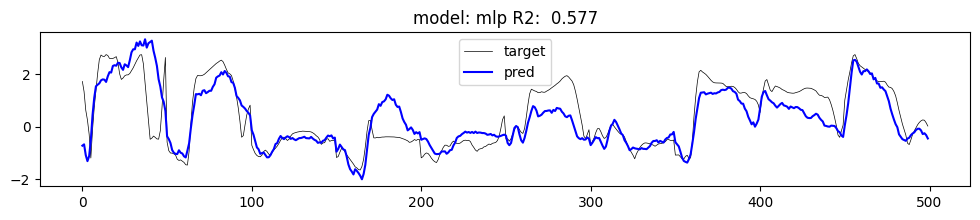

In [22]:
r2, test_pred, test_y = eval_model(dm.train, dm.test, model, model_type="mlp", plot=True)